In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
from PIL import Image

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [4]:
#from tensorflow.keras.preprocessing import image_dataset_from_directory

In [5]:
from tensorflow.keras.optimizers import Adam, SGD

In [6]:
train_datagen = ImageDataGenerator(
        rotation_range=40,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

In [7]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [8]:
batch_size = 32

## vet all files can be workable with Tensorflow

In [9]:
# import pandas as pd
# import numpy as np
# df=pd.read_csv('../data/cleaned_data.csv')

In [10]:
# df

In [11]:
# train_datagen.flow_from_dataframe(
# )

In [12]:
train_generator = train_datagen.flow_from_directory(
        '../data/train_folder',  # this is the target directory
        target_size=(150, 150),  # all images will be resized to 150x150
        batch_size=batch_size,
        color_mode="rgb",
        class_mode='categorical')  # since we use binary_crossentropy loss, we need binary labels

Found 10254 images belonging to 12 classes.


In [13]:
validation_generator = test_datagen.flow_from_directory(
        '../data/validation_folder',
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='categorical')

Found 1140 images belonging to 12 classes.


In [14]:
steps_per_epoch = 100
epoch  = 50
def my_gen(gen):
    i=0
    while i < steps_per_epoch * epoch:
        try:
            data, labels = next(gen)
            i+=1
            yield data, labels
        except:
            pass

In [15]:
from tensorflow.keras import backend as K
img_width, img_height = 150, 150
if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

In [ ]:
from tensorflow.keras import callbacks
my_callbacks = [
    callbacks.EarlyStopping(monitor='loss', mode= 'min', patience=5),
    callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=0,
    min_delta=0.001, cooldown=1, min_lr=0, mode = 'min')
]

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(input_shape)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

#model.add(Dropout(0.5))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

#model.add(Dropout(0.5))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

#model.add(Dropout(0.5))

# model.add(Conv2D(64, (3, 3)))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))


# model.add(Conv2D(64, (3, 3)))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(12))
model.add(Activation('softmax'))

optimizer = SGD(lr=0.005)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 72, 72, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        1

In [18]:
hist= model.fit(
        my_gen(train_generator),
        steps_per_epoch=steps_per_epoch,
        epochs=epoch,
        validation_data=validation_generator,callbacks=)

Epoch 1/50
100/100 [==============================] - 19s 189ms/step - loss: 2.4859 - accuracy: 0.0866 - val_loss: 2.4764 - val_accuracy: 0.0947
Epoch 2/50
100/100 [==============================] - 19s 187ms/step - loss: 2.4797 - accuracy: 0.0922 - val_loss: 2.4731 - val_accuracy: 0.1377
Epoch 3/50
100/100 [==============================] - 19s 186ms/step - loss: 2.4749 - accuracy: 0.0975 - val_loss: 2.4690 - val_accuracy: 0.0860
Epoch 4/50
100/100 [==============================] - 19s 186ms/step - loss: 2.4683 - accuracy: 0.1069 - val_loss: 2.4607 - val_accuracy: 0.1509
Epoch 5/50
100/100 [==============================] - 19s 188ms/step - loss: 2.4634 - accuracy: 0.1056 - val_loss: 2.4508 - val_accuracy: 0.1272
Epoch 6/50
100/100 [==============================] - 19s 187ms/step - loss: 2.4560 - accuracy: 0.1166 - val_loss: 2.4400 - val_accuracy: 0.1272
Epoch 7/50
100/100 [==============================] - 19s 185ms/step - loss: 2.4466 - accuracy: 0.1304 - val_loss: 2.4226 - val_ac

In [19]:
test_loss, test_acc = model.evaluate(X_test_f, y_test_f, verbose=0)

print('\nTest accuracy {:5.2f}%'.format(100*test_acc))

NameError: name 'X_test_f' is not defined

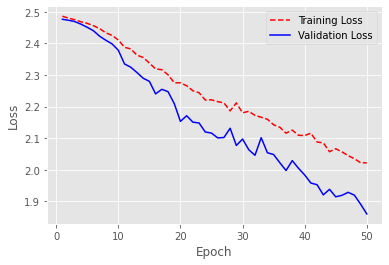

In [20]:
%load_ext autoreload
#Wedutoreload 2

import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')
training_loss = hist.history['loss']
test_loss = hist.history['val_loss']

epoch_count = range(1,len(training_loss)+1)

plt.plot(epoch_count,training_loss,'r--')
plt.plot(epoch_count,test_loss,'b-')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

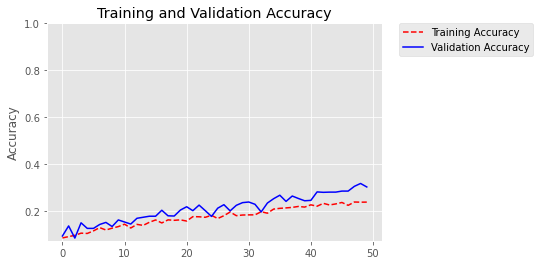

In [21]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

epoch_count = range(1,len(training_loss)+1)

plt.plot(acc, 'r--', label='Training Accuracy')
plt.plot(val_acc, 'b-', label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy');

plt.legend(bbox_to_anchor=(1.05,1),loc=2,borderaxespad=0)